## Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib

# Tensorflow libraries
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

#matplotlib style
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['legend.frameon'] = False

# Project package
from src.plot_functions import plot_acc_loss
from src.training_functions import exp_decay, train_lrscheduler
from src.init_data import create_train_val_data_from_directory

## Create binary classif dataset

In [2]:
# create datasets

data_dir_bin = "/home/titou/Documents/git/flower_image_class/data/flower_photos_binary/"
data_dir_bin = pathlib.Path(data_dir_bin)


# parameters
batch_size = 32
img_height = 180
img_width = 180

train_ds_bin, validation_ds_bin = create_train_val_data_from_directory(data_dir_bin)

class_names_bin = train_ds_bin.class_names
num_classes_bin = len(class_names_bin)
print(class_names_bin)

#Preformance improvement for the IO part of the training

AUTOTUNE = tf.data.AUTOTUNE

train_ds_bin = train_ds_bin.cache().shuffle(1000, seed=123).prefetch(buffer_size=AUTOTUNE)
validation_ds_bin = validation_ds_bin.cache().prefetch(buffer_size=AUTOTUNE)


Found 1274 files belonging to 2 classes.
Using 1020 files for training.
Found 1274 files belonging to 2 classes.
Using 254 files for validation.
['daisy', 'roses']


2022-07-21 13:01:02.608686: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-21 13:01:02.612116: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-21 13:01:02.612290: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-21 13:01:02.612610: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

## Fine tune Resnet for binary classification

In [3]:
resnet50 = tf.keras.models.load_model('../data/pretrained_models/resnet50_nopooling.h5')
resnet50.trainable=False

In [4]:
# Create the new model

def create_resnet(num_classes):

    model = Sequential([

        layers.Resizing(img_height, img_width),
        layers.Rescaling(1./255),
        # Data augmentation
        #layers.RandomFlip("horizontal", seed=123),
        #layers.RandomRotation(0.05, seed=123),
        #layers.GaussianNoise(0.1, seed=123),

        resnet50,
        layers.MaxPool2D(),
        layers.Flatten(),
        layers.Dropout(0.2, seed=123),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes)
    ])


    opt=tf.keras.optimizers.Adam(learning_rate=1e-3)

    model.compile(
        optimizer=opt,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

    return model

  

Epoch 1/10


2022-07-21 13:01:13.491409: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-07-21 13:01:14.026936: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-07-21 13:01:14.027294: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-07-21 13:01:14.027314: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-07-21 13:01:14.027676: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-07-21 13:01:14.027719: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


 4/32 [==>...........................] - ETA: 1s - loss: 3.4228 - accuracy: 0.7188

2022-07-21 13:01:15.225266: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


32/32 [==============================] - 8s 127ms/step - loss: 0.8438 - accuracy: 0.8961 - val_loss: 0.1341 - val_accuracy: 0.9528 - lr: 0.0010
Epoch 2/10
32/32 [==============================] - 2s 67ms/step - loss: 0.0516 - accuracy: 0.9775 - val_loss: 0.1647 - val_accuracy: 0.9409 - lr: 0.0010
Epoch 3/10
32/32 [==============================] - 2s 66ms/step - loss: 0.0154 - accuracy: 0.9961 - val_loss: 0.1955 - val_accuracy: 0.9567 - lr: 0.0010
Epoch 4/10
32/32 [==============================] - 2s 71ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.2180 - val_accuracy: 0.9528 - lr: 0.0010
Epoch 5/10
32/32 [==============================] - 2s 67ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.2244 - val_accuracy: 0.9488 - lr: 0.0010
Epoch 6/10
32/32 [==============================] - 2s 67ms/step - loss: 5.3841e-04 - accuracy: 1.0000 - val_loss: 0.2258 - val_accuracy: 0.9528 - lr: 0.0010
Epoch 7/10
32/32 [==============================] - 2s 67ms/step - loss: 2.4843e-0

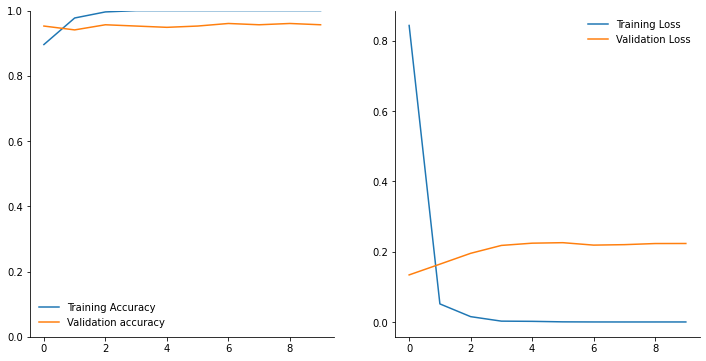

In [5]:
resnet = create_resnet(num_classes_bin)
epochs = 10
resnet_history = train_lrscheduler(resnet, epochs, train_ds_bin, validation_ds_bin, exp_decay)
plot_acc_loss(resnet_history, epochs)

